In [1]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from operator import itemgetter 

In [2]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))

In [3]:
def data_processing(country, adr, fx_dict, forex_bps = 10, adjust_forex_expense = True):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open', 'volume' : 'adr_volume'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open', 'volume' : 'stock_volume'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data so that all prices are reflected in USD
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,3,5,4,6,8,7,9,11,10,12]].copy()
        inverted_fx_df.columns = fx_df.columns[1:-1]
        fx_df.iloc[:,1:-1] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close', 'adr_volume']], stock_df.loc[:,['date', 'stock_open','stock_close', 'stock_volume']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     ratio is (stock price in USD)/(ADR price)
#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]    
    
    if adjust_forex_expense:
        # Added expense for trading small amounts in forex market
        forex_bid_multiplier = 1 - 0.0001*forex_bps
        forex_ask_multiplier = 1 + 0.0001*forex_bps
        merged_df.loc[:,merged_df.columns.str.contains("bid")] *= forex_bid_multiplier
        merged_df.loc[:,merged_df.columns.str.contains("ask")] *= forex_ask_multiplier
        
    return merged_df

In [4]:
def calc_max_drawdown(portfolio_values, method = "percentage"):
    peak, trough = portfolio_values[0], portfolio_values[0]
    max_drawdown = 0
    for i in range(1, len(portfolio_values)):
        if portfolio_values[i] < trough:
            trough = portfolio_values[i]
            if method == "percentage":
                max_drawdown = max(max_drawdown, (peak - trough)/peak)
            else:
                max_drawdown = max(max_drawdown, peak - trough)
        elif portfolio_values[i] > peak:
            peak, trough = portfolio_values[i], portfolio_values[i]
    return max_drawdown

In [5]:
def get_risk_statistics(stock_values, adr_values, var_ci):
    port_stock = stock_values - adr_values
    port = pd.DataFrame(data = port_stock)
    port_diff = port - port.shift(1)
    pnl = pd.DataFrame(port_diff).dropna()
    sigma = pnl.std()[0]
    pnl['pct_rank'] = pnl.rank(pct=True)
    pnl.columns =['daily_pl', 'pct_rank']
    var = abs(pnl[pnl.pct_rank< 1-var_ci].daily_pl.max())
    max_drawdown_abs = calc_max_drawdown(port_stock, "absolute")
    return sigma, var, max_drawdown_abs

In [6]:
def plot_returns(dates, portfolio_values, num_xticks = 5):
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();

In [7]:
def calc_sharpe(portfolio_values):
    portfolio_values = np.array(portfolio_values)
    returns = (portfolio_values[1:] - portfolio_values[:-1])/portfolio_values[:-1]
    return np.round(np.sqrt(252)*np.mean(returns)/np.std(returns), 2)

In [8]:
list_pairs_copy = list_pairs.copy()
list_pairs_aus = list_pairs[:9]
list_pairs_chi = list_pairs[9:18]
list_pairs_jap = list_pairs[18:]

In [9]:
#list_pairs = list_pairs_aus
#list_pairs = list_pairs_chi
list_pairs = list_pairs_jap
#list_pairs = list_pairs_copy
#list_pairs = [list_pairs_copy[0]]

# Global Variant 1

In [31]:
df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    # Should be read in from file
    hp_dict[(country, adr)] = {}
    hp_dict[(country, adr)]["lookback"] = 100
    hp_dict[(country, adr)]["entry"] = 1
    hp_dict[(country, adr)]["exit"] = 0
    hp_dict[(country, adr)]["stop_loss"] = 3
    hp_dict[(country, adr)]["allocation"] = 1/len(list_pairs)
    
diff_record_dict = {}
for (country, adr) in list_pairs:
    diff_record_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
forex_dict = {}
for (country, adr) in list_pairs:
    forex_dict[(country, adr)] = {}
    forex_dict[(country, adr)]["forex_cash"] = 0
    forex_dict[(country, adr)]["prev_forex_value"] = 0
    
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 250000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
stop_loss_limit = 0.15
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [32]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                prev_value += forex_dict[(country, adr)]["prev_forex_value"]
            
        portfolio_values.append(prev_value)
        
        # risk tests
        max_drawdown = calc_max_drawdown(portfolio_values, method = "absolute")
        cum_pl = prev_value - starting_cash
        liquid
        
        elif max_drawdown > max_drawdown_limit*starting_cash or cum_pl < -stop_loss_limit*starting_cash:
            # Liquidate
            
        elif max_drawdown > 0.75*max_drawdown_limit*starting_cash or cum_pl < -0.75*stop_loss_limit*starting_cash:
            # Liquidate half of positions
            
        elif max_drawdown > 0.5*max_drawdown_limit*starting_cash or cum_pl < -0.5*stop_loss_limit*starting_cash:
            # Liquidate a third of positions
            
        # Calculate VaR and sigma test everyday right before Asian open
        stock_values = np.zeros(risk_lookback)
        adr_values = np.zeros(risk_lookback)
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            if index > 0:
                temp_risk_lookback = min(risk_lookback, index)
                current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                ind_stock_values = (np.array(current["stock_close"])/np.array(next_day["avg_non_us_before"]))*positions[(country, adr)]["stock_pos"] 
                ind_adr_values = np.array(current["adr_close"]*positions[(country, adr)]["adr_pos"])
                stock_values[-len(ind_stock_values):] += ind_stock_values
                adr_values[-len(ind_adr_values):] += ind_adr_values
        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
        if sigma > prev_value*sigma_limit:
            print("Sigma: {}".format(sigma))
        if var > prev_value*var_limit:
            print("VaR: {}".format(var))
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                forex_dict[(country, adr)]["forex_cash"] *= multiplier
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record = diff_record_dict[(country, adr)]
                    diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])

                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record) < lookback or row["date"] < start_date or merged_df.loc[index+1, "date"] > end_date:
                        continue

                    mean = np.array(diff_record).mean()
                    std = np.array(diff_record).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record[-1] > mean + entry*std and diff_record[-1] <= mean + stop_loss*std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                            
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                            stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                            adr_values = np.array(current["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                            
                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                    # Liquidation condition
                    elif (diff_record[-1] < mean + exit*std or 
                          diff_record[-1] > mean + stop_loss*std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                            if forex_dict[(country, adr)]["forex_cash"] > 0:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                            else:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash += forex_dict[(country, adr)]["forex_cash"]
                            prev_cash += forex_dict[(country, adr)]["forex_cash"]
                            forex_dict[(country, adr)]["forex_cash"] = 0
                                
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

MDD: 106581.13861320482
MDD: 119082.73040224751
MDD: 119082.73040224751
MDD: 119082.73040224751
MDD: 125609.1425421572
MDD: 125609.1425421572
MDD: 125609.1425421572
MDD: 125609.1425421572
MDD: 125609.1425421572
MDD: 127690.08865302743
MDD: 127690.08865302743
MDD: 127690.08865302743
MDD: 127690.08865302743
MDD: 127690.08865302743
MDD: 128123.78756638686
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.17064064974
MDD: 128657.170640649

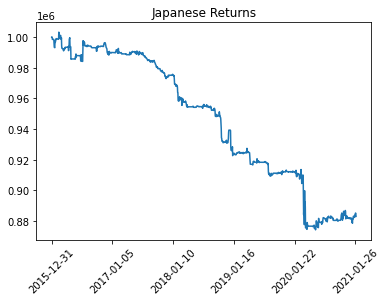

Opening positions:
We bought 1219 shares of underlying stock (6758) at the price of 3016.0129999999995 foreign dollars on 2016-01-05
We sold 1219 shares of ADR (SONY) at the price of 24.21576 on 2016-01-06
Closing positions:
We sold 1219 shares of underlying stock (6758) at the price of 2794.7025 foreign dollars on 2016-01-06
We bought 1219 shares of ADR (SONY) at the price of 23.543519999999997 on 2016-01-07
Opening positions:
We bought 165 shares of underlying stock (8591) at the price of 1599.0974999999999 foreign dollars on 2016-01-12
We sold 33 shares of ADR (IX) at the price of 68.51142 on 2016-01-13
Opening positions:
We bought 82 shares of underlying stock (8411) at the price of 2262.2599999999998 foreign dollars on 2016-01-12

Sharpe Ratio: -0.97


In [33]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

# Global Variant 2

In [13]:
df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    # Should be read in from file
    hp_dict[(country, adr)] = {}
    hp_dict[(country, adr)]["lookback"] = 100
    hp_dict[(country, adr)]["entry"] = 1
    hp_dict[(country, adr)]["exit"] = 0
    hp_dict[(country, adr)]["stop_loss"] = 3
    hp_dict[(country, adr)]["allocation"] = 1/len(list_pairs)
    
diff_record_dict = {}
for (country, adr) in list_pairs:
    diff_record_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    
forex_dict = {}
for (country, adr) in list_pairs:
    forex_dict[(country, adr)] = {}
    forex_dict[(country, adr)]["forex_cash"] = 0
    forex_dict[(country, adr)]["prev_forex_value"] = 0
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 250000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
stop_loss_limit = 0.15
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [14]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                prev_value += forex_dict[(country, adr)]["prev_forex_value"]
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                forex_dict[(country, adr)]["forex_cash"] *= multiplier
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record = diff_record_dict[(country, adr)]
                    diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                    
                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    if len(diff_record) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    mean = np.array(diff_record).mean()
                    std = np.array(diff_record).std()

                    entry = hp_dict[(country, adr)]["entry"]
                    exit = hp_dict[(country, adr)]["exit"]
                    stop_loss = hp_dict[(country, adr)]["stop_loss"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]

                    if diff_record[-1] > mean + entry*std and diff_record[-1] <= mean + stop_loss*std:
                        if stock_pos == 0 and adr_pos == 0:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    continue
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                                
                            adr_pos -= adr_quantity
                            positions[(country, adr)]["adr_pos"] -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            positions[(country, adr)]["stock_pos"] += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity

                            positions[(country, adr)]["holding_period"] = 0
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            
                    # Liquidation condition
                    elif (diff_record[-1] < mean + exit*std or 
                          diff_record[-1] > mean + stop_loss*std or 
                          holding_period == maximum_holding_period):
                        if stock_pos > 0 and adr_pos < 0 : 
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                            if forex_dict[(country, adr)]["forex_cash"] > 0:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                            else:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash += forex_dict[(country, adr)]["forex_cash"]
                            forex_dict[(country, adr)]["forex_cash"] = 0

                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None

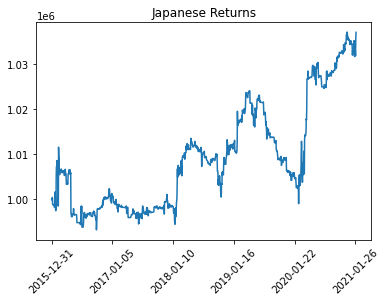

Opening positions:
We sold 649 shares of ADR (HMC) at the price of 30.82914 on 2016-01-04
We bought 649 shares of underlying stock (7267) at the price of 3733.7299999999996 foreign dollars on 2016-01-04
Opening positions:
We sold 2600 shares of ADR (SMFG) at the price of 7.45254 on 2016-01-06
We bought 520 shares of underlying stock (8316) at the price of 4439.4349999999995 foreign dollars on 2016-01-06
Opening positions:
We sold 1219 shares of ADR (SONY) at the price of 24.21576 on 2016-01-06
We bought 1219 shares of underlying stock (6758) at the price of 2800.2974999999997 foreign dollars on 2016-01-06
Opening positions:
We sold 476 shares of ADR (TM) at the price of 118.45142999999999 on 2016-01-06

Sharpe Ratio: 0.44


In [15]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

# Global Variant 3(a)

In [16]:
df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    hp_dict[(country, adr)] = {}
    # Should be read in from file
    hp_dict[(country, adr)]["lookback"] = 100
    hp_dict[(country, adr)]["entry_cond1_val"] = 1
    hp_dict[(country, adr)]["entry_cond2_val"] = 1
    hp_dict[(country, adr)]["exit_cond1_val"] = 0
    hp_dict[(country, adr)]["exit_cond2_val"] = 0
    hp_dict[(country, adr)]["stop_loss_cond1"] = 3
    hp_dict[(country, adr)]["stop_loss_cond2"] = 3
    hp_dict[(country, adr)]["allocation"] = 1/len(list_pairs)
    
diff_record_cond1_dict = {}
diff_record_cond2_dict = {}
for (country, adr) in list_pairs:
    diff_record_cond1_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    diff_record_cond2_dict[(country, adr)] = deque(maxlen = hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    positions[(country, adr)]["trade_type"] = None
    
conditions = {}
for (country, adr) in list_pairs:
    conditions[(country, adr)] = {}
    conditions[(country, adr)]["enter_cond1"] = False
    conditions[(country, adr)]["exit_cond1"] = False
    conditions[(country, adr)]["enter_cond2"] = False
    conditions[(country, adr)]["exit_cond2"] = False
    
forex_dict = {}
for (country, adr) in list_pairs:
    forex_dict[(country, adr)] = {}
    forex_dict[(country, adr)]["forex_cash"] = 0
    forex_dict[(country, adr)]["prev_forex_value"] = 0
    
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)    
    
cash = 250000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [17]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                prev_value += forex_dict[(country, adr)]["prev_forex_value"]
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                forex_dict[(country, adr)]["forex_cash"] *= multiplier
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record_cond1 = diff_record_cond1_dict[(country, adr)]
                    diff_record_cond2 = diff_record_cond2_dict[(country, adr)]
                    diff_record_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                    diff_record_cond2.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
                    
                    # We place one trade the day itself (Asian), one trade the day after (US)
                    lookback = hp_dict[(country, adr)]["lookback"]
                    
                    # row["date"] is between start_date (inclusive) and end_date (inclusive)
                    if len(diff_record_cond1) < lookback or row["date"] < start_date or row["date"] > end_date:
                        continue

                    mean_cond1 = np.array(diff_record_cond1).mean()
                    std_cond1 = np.array(diff_record_cond1).std()
                    mean_cond2 = np.array(diff_record_cond2).mean()
                    std_cond2 = np.array(diff_record_cond2).std()

                    entry_cond1_val = hp_dict[(country, adr)]["entry_cond1_val"]
                    entry_cond2_val = hp_dict[(country, adr)]["entry_cond2_val"]
                    exit_cond1_val = hp_dict[(country, adr)]["exit_cond1_val"]
                    exit_cond2_val = hp_dict[(country, adr)]["exit_cond2_val"]
                    stop_loss_cond1 = hp_dict[(country, adr)]["stop_loss_cond1"]
                    stop_loss_cond2 = hp_dict[(country, adr)]["stop_loss_cond2"]
                    stock_pos = positions[(country, adr)]["stock_pos"]
                    adr_pos = positions[(country, adr)]["adr_pos"]
                    holding_period = positions[(country, adr)]["holding_period"]
                    trade_type = positions[(country, adr)]["trade_type"]
                    stock_name = adr.split("_")[1]
                    adr_name = adr.split("_")[0]
                    
                    enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                    exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                    enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                    exit_cond2 = conditions[(country, adr)]["exit_cond2"]
                    
                    if not (enter_cond2 or exit_cond2):
                        enter_cond1 = (diff_record_cond1[-1] > mean_cond1 + entry_cond1_val*std_cond1 
                                       and diff_record_cond1[-1] <= mean_cond1 + stop_loss_cond1*std_cond1
                                       and stock_pos == 0 and adr_pos == 0)
                        exit_cond1 = ((diff_record_cond1[-1] < mean_cond1 + exit_cond1_val*std_cond1 
                                      or diff_record_cond1[-1] > mean_cond1 + stop_loss_cond1*std_cond1
                                      or (holding_period == maximum_holding_period and trade_type == 1))
                                      and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond1:
                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                            adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    enter_cond1 = False
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                                
                            if units != 0:
                                adr_pos -= adr_quantity
                                positions[(country, adr)]["adr_pos"] -= adr_quantity
                                adr_px = row['adr_open']*short_multiplier
                                cash += adr_quantity*adr_px
                                prev_cash += adr_quantity*adr_px
                                
                                stock_pos += stock_quantity
                                positions[(country, adr)]["stock_pos"] += stock_quantity
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                positions[(country, adr)]["holding_period"] = 0
                                positions[(country, adr)]["trade_type"] = 1
                                
                                trade_records.append("Opening positions:\n")
                                # Times in EST
                                trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                        elif exit_cond1:
                            adr_px = row['adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            prev_cash -= abs(adr_pos)*adr_px
                            
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                            if forex_dict[(country, adr)]["forex_cash"] > 0:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                            else:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash += forex_dict[(country, adr)]["forex_cash"]
                            prev_cash += forex_dict[(country, adr)]["forex_cash"]
                            forex_dict[(country, adr)]["forex_cash"] = 0
                            
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            
                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                            
                        conditions[(country, adr)]["enter_cond1"] = enter_cond1
                        conditions[(country, adr)]["exit_cond1"] = exit_cond1
                            
                    if not (enter_cond1 or exit_cond1) and merged_df.loc[index+1, "date"] <= end_date:
                        
                        # Check and possibly trade condition 2
                        enter_cond2 = (diff_record_cond2[-1] > mean_cond2 + entry_cond2_val*std_cond2 
                               and diff_record_cond2[-1] <= mean_cond2 + stop_loss_cond2*std_cond2
                               and stock_pos == 0 and adr_pos == 0)
                        exit_cond2 = ((diff_record_cond2[-1] < mean_cond2 + exit_cond2_val*std_cond2 
                              or diff_record_cond2[-1] > mean_cond2 + stop_loss_cond2*std_cond2
                              or (holding_period == maximum_holding_period and trade_type == 2))
                              and stock_pos > 0 and adr_pos < 0)
                        
                        if enter_cond2:

                            portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                            adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                            stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                            units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                            (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                            adr_volume, 
                                            stock_volume))
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])

                            # Take portfolio value for each previous day when the Asian market opens
                            temp_risk_lookback = min(risk_lookback, index)
                            current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                            next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                            stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                            adr_values = np.array(current["adr_close"]*adr_quantity)
                            sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                            if (var > portfolio_value_before_entering*var_limit or 
                                max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                sigma > portfolio_value_before_entering*sigma_limit):
                                frac = min((portfolio_value_before_entering*var_limit)/var, 
                                           (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                          (portfolio_value_before_entering*sigma_limit)/sigma)
                                units = int(frac*units)
                                if units == 0:
                                    enter_cond2 = False
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])   
                            if units != 0:
                                stock_pos += stock_quantity
                                positions[(country, adr)]["stock_pos"] += stock_quantity
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                adr_pos -= adr_quantity
                                positions[(country, adr)]["adr_pos"] -= adr_quantity
                                adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                cash += adr_quantity*adr_px

                                positions[(country, adr)]["holding_period"] = 0
                                positions[(country, adr)]["trade_type"] = 2
                                trade_records.append("Opening positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                        # Liquidation condition
                        elif exit_cond2:
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                            forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                            if forex_dict[(country, adr)]["forex_cash"] > 0:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                            else:
                                forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                            cash += forex_dict[(country, adr)]["forex_cash"]
                            prev_cash += forex_dict[(country, adr)]["forex_cash"]
                            forex_dict[(country, adr)]["forex_cash"] = 0
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                            cash -= abs(adr_pos)*adr_px
                            trade_records.append("Closing positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            positions[(country, adr)]["stock_pos"] = 0
                            positions[(country, adr)]["adr_pos"] = 0
                            positions[(country, adr)]["holding_period"] = None
                            positions[(country, adr)]["trade_type"] = None
                            
                        conditions[(country, adr)]["enter_cond2"] = enter_cond2
                        conditions[(country, adr)]["exit_cond2"] = exit_cond2

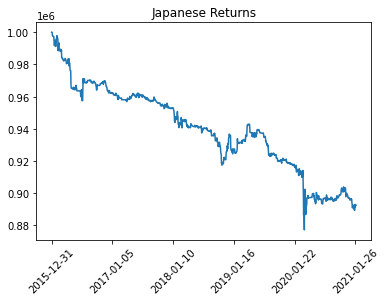

Opening positions:
We sold 649 shares of ADR (HMC) at the price of 30.82914 on 2016-01-04
We bought 649 shares of underlying stock (7267) at the price of 3733.7299999999996 foreign dollars on 2016-01-04
Opening positions:
We bought 1219 shares of underlying stock (6758) at the price of 3016.0129999999995 foreign dollars on 2016-01-05
We sold 1219 shares of ADR (SONY) at the price of 24.21576 on 2016-01-06
Closing positions:
We sold 649 shares of underlying stock (7267) at the price of 3622.374 foreign dollars on 2016-01-06
We bought 649 shares of ADR (HMC) at the price of 29.779749999999996 on 2016-01-07
Opening positions:
We sold 2600 shares of ADR (SMFG) at the price of 7.45254 on 2016-01-06

Sharpe Ratio: -0.87


In [18]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))

# Global Variant 3(b)

In [19]:
df_dict = {}
for (country, adr) in list_pairs_copy:
    df_dict[(country, adr)] = data_processing(country, adr, fx_dict)
    
hp_dict = {}
for (country, adr) in list_pairs:
    ind_hp_dict = {}
    # Should be read in from file
    ind_hp_dict["lookback"] = 100
    ind_hp_dict["entry_cond1_val"] = 1
    ind_hp_dict["entry_cond2_val"] = 1
    ind_hp_dict["exit_cond1_val"] = 0
    ind_hp_dict["exit_cond2_val"] = 0
    ind_hp_dict["stop_loss_cond1"] = 3
    ind_hp_dict["stop_loss_cond2"] = 3
    ind_hp_dict["allocation"] = 1/len(list_pairs)
    hp_dict[(country, adr)] = ind_hp_dict
    
diff_record_dict = {}
for (country, adr) in list_pairs:
    diff_record_dict[(country, adr)] = deque(maxlen = 2*hp_dict[(country, adr)]["lookback"])
    
iter_dict = {}
for (country, adr) in list_pairs:
    iter_dict[(country, adr)] = {}
    iter_dict[(country, adr)]["index"] = 0
    
positions = {}
for (country, adr) in list_pairs:
    positions[(country, adr)] = {}
    positions[(country, adr)]["stock_pos"] = 0
    positions[(country, adr)]["adr_pos"] = 0
    positions[(country, adr)]["prev_adr_pos"] = 0
    positions[(country, adr)]["holding_period"] = None
    positions[(country, adr)]["trade_type"] = None
    
conditions = {}
for (country, adr) in list_pairs:
    conditions[(country, adr)] = {}
    conditions[(country, adr)]["enter_cond1"] = False
    conditions[(country, adr)]["exit_cond1"] = False
    conditions[(country, adr)]["enter_cond2"] = False
    conditions[(country, adr)]["exit_cond2"] = False
    
forex_dict = {}
for (country, adr) in list_pairs:
    forex_dict[(country, adr)] = {}
    forex_dict[(country, adr)]["forex_cash"] = 0
    forex_dict[(country, adr)]["prev_forex_value"] = 0
    
#datelist = list(map(lambda x : str(x).split()[0], pd.date_range(start='2015-04-01', end='2021-01-31', freq = "D").tolist()))
date_set = set()
for (country, adr) in list_pairs_copy:
    date_set = date_set.union(set(df_dict[(country, adr)]["date"]))
datelist = sorted(date_set)
    
cash = 250000
trade_records = []
portfolio_values = []
dates = []
start_date = "2016-01-01"
end_date = "2021-01-31"
slippage_bps = 10
forex_bps = 10
borrowing_bps = 50
risk_lookback = 100
var_ci = 0.95
var_limit = 0.1
max_drawdown_limit = 0.2
sigma_limit = 0.05
maximum_holding_period = 30
volume_lookback = 5

short_multiplier = 1 - 0.0001*slippage_bps
long_multiplier = 1 + 0.0001*slippage_bps
starting_cash = cash
# For book-keeping, since we shall store the portfolio value of the day before
prev_cash = cash

In [20]:
for i in range(1, len(datelist)):
    current_date = datelist[i]
    prev_date = datelist[i-1]
    if current_date >= start_date and prev_date <= end_date:
        dates.append(prev_date)
        prev_value = prev_cash
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            row = merged_df.loc[index]
            if index > 0:
                # Add adr values
                prev_value += positions[(country, adr)]["prev_adr_pos"]*merged_df.loc[index - 1, 'adr_close']
                # Add stock values
                forex_dict[(country, adr)]["prev_forex_value"] = forex_dict[(country, adr)]["forex_cash"] 
                forex_dict[(country, adr)]["prev_forex_value"] += positions[(country, adr)]["stock_pos"]*row['stock_open']
                if forex_dict[(country, adr)]["prev_forex_value"] > 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_ask_non_us_at']
                elif forex_dict[(country, adr)]["prev_forex_value"] < 0:
                    forex_dict[(country, adr)]["prev_forex_value"] /= row['avg_bid_non_us_at']
                prev_value += forex_dict[(country, adr)]["prev_forex_value"]
        portfolio_values.append(prev_value)
        
        for (country, adr) in list_pairs:
            index = iter_dict[(country, adr)]["index"]
            merged_df = df_dict[(country, adr)]
            positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
            if positions[(country, adr)]["stock_pos"] > 0:
                positions[(country, adr)]["holding_period"] += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(positions[(country, adr)]["adr_pos"])*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + merged_df.loc[index]["ir"])*(1/252))
                forex_dict[(country, adr)]["forex_cash"] *= multiplier
        prev_cash = cash
        
    for (country, adr) in list_pairs:
        index = iter_dict[(country, adr)]["index"]
        merged_df = df_dict[(country, adr)]
        if index+1 < len(merged_df):
            row = merged_df.loc[index]
            if row["date"] == current_date:
                iter_dict[(country, adr)]["index"] += 1
                if index > 0: 
                    diff_record = diff_record_dict[(country, adr)]
                    diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
                    lookback = 2*hp_dict[(country, adr)]["lookback"]
                    if len(diff_record) == lookback and row["date"] >= start_date and row["date"] <= end_date:
                        mean = np.array(diff_record).mean()
                        std = np.array(diff_record).std()
                        
                        entry_cond1_val = hp_dict[(country, adr)]["entry_cond1_val"]
                        entry_cond2_val = hp_dict[(country, adr)]["entry_cond2_val"]
                        exit_cond1_val = hp_dict[(country, adr)]["exit_cond1_val"]
                        exit_cond2_val = hp_dict[(country, adr)]["exit_cond2_val"]
                        stop_loss_cond1 = hp_dict[(country, adr)]["stop_loss_cond1"]
                        stop_loss_cond2 = hp_dict[(country, adr)]["stop_loss_cond2"]
                        stock_pos = positions[(country, adr)]["stock_pos"]
                        adr_pos = positions[(country, adr)]["adr_pos"]
                        holding_period = positions[(country, adr)]["holding_period"]
                        trade_type = positions[(country, adr)]["trade_type"]
                        stock_name = adr.split("_")[1]
                        adr_name = adr.split("_")[0]

                        enter_cond1 = conditions[(country, adr)]["enter_cond1"]
                        exit_cond1 = conditions[(country, adr)]["exit_cond1"]
                        enter_cond2 = conditions[(country, adr)]["enter_cond2"]
                        exit_cond2 = conditions[(country, adr)]["exit_cond2"]
                    
                        if not (enter_cond2 or exit_cond2):
                            enter_cond1 = (diff_record[-1] > mean + entry_cond1_val*std
                                   and diff_record[-1] <= mean + stop_loss_cond1*std
                                   and stock_pos == 0 and adr_pos == 0)
                            exit_cond1 = ((diff_record[-1] < mean + exit_cond1_val*std
                                          or diff_record[-1] > mean + stop_loss_cond1*std
                                          or (holding_period == maximum_holding_period and trade_type == 1))
                                          and stock_pos > 0 and adr_pos < 0)

                            if enter_cond1:
                                portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/merged_df.loc[index-1,'adr_close_per_unit'],
                                                (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_us_before']), 
                                                adr_volume, 
                                                stock_volume))
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])

                                # Take portfolio value for each previous day when the Asian market opens
                                temp_risk_lookback = min(risk_lookback, index)
                                current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                                adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                if (var > portfolio_value_before_entering*var_limit or 
                                    max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                    sigma > portfolio_value_before_entering*sigma_limit):
                                    frac = min((portfolio_value_before_entering*var_limit)/var, 
                                               (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                              (portfolio_value_before_entering*sigma_limit)/sigma)
                                    units = int(frac*units)
                                    if units == 0:
                                        enter_cond1 = False
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])   
                                if units != 0:

                                    adr_pos -= adr_quantity
                                    positions[(country, adr)]["adr_pos"] -= adr_quantity
                                    adr_px = row['adr_open']*short_multiplier
                                    cash += adr_quantity*adr_px
                                    prev_cash += adr_quantity*adr_px

                                    stock_pos += stock_quantity
                                    positions[(country, adr)]["stock_pos"] += stock_quantity
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity

                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]
                                    positions[(country, adr)]["holding_period"] = 0
                                    positions[(country, adr)]["trade_type"] = 1

                                    trade_records.append("Opening positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                            elif exit_cond1:
                                adr_px = row['adr_open']*long_multiplier
                                cash -= abs(adr_pos)*adr_px
                                prev_cash -= abs(adr_pos)*adr_px

                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                if forex_dict[(country, adr)]["forex_cash"] > 0:
                                    forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                else:
                                    forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash += forex_dict[(country, adr)]["forex_cash"]
                                prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                forex_dict[(country, adr)]["forex_cash"] = 0

                                trade_records.append("Closing positions:\n")
                                # Times in EST
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {row['date']}\n")
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                                positions[(country, adr)]["stock_pos"] = 0
                                positions[(country, adr)]["adr_pos"] = 0
                                positions[(country, adr)]["holding_period"] = None
                                positions[(country, adr)]["trade_type"] = None

                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                            conditions[(country, adr)]["enter_cond1"] = enter_cond1
                            conditions[(country, adr)]["exit_cond1"] = exit_cond1
                            
                    diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
                    if len(diff_record) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                        mean = np.array(diff_record).mean()
                        std = np.array(diff_record).std()
                        
                        if not (enter_cond1 or exit_cond1):

                            # Check and possibly trade condition 2
                            enter_cond2 = (diff_record[-1] > mean + entry_cond2_val*std
                                   and diff_record[-1] <= mean + stop_loss_cond2*std
                                   and stock_pos == 0 and adr_pos == 0)
                            exit_cond2 = ((diff_record[-1] < mean + exit_cond2_val*std
                                          or diff_record[-1] > mean + stop_loss_cond2*std
                                          or (holding_period == maximum_holding_period and trade_type == 2))
                                          and stock_pos > 0 and adr_pos < 0)

                            if enter_cond2:

                                portfolio_value_before_entering = portfolio_values[-1] if portfolio_values else cash
                                adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                                stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                                units = int(min((hp_dict[(country, adr)]["allocation"]*cash)/row['adr_close_per_unit'],
                                                (hp_dict[(country, adr)]["allocation"]*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                                adr_volume, 
                                                stock_volume))
                                adr_quantity = int(units*row["adr_num_per_unit"])
                                stock_quantity = int(units*row["stock_num_per_unit"])

                                # Take portfolio value for each previous day when the Asian market opens
                                temp_risk_lookback = min(risk_lookback, index)
                                current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                                next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                                stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                                adr_values = np.array(current["adr_close"]*adr_quantity)
                                sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                                if (var > portfolio_value_before_entering*var_limit or 
                                    max_drawdown_abs > max_drawdown_limit*starting_cash or 
                                    sigma > portfolio_value_before_entering*sigma_limit):
                                    frac = min((portfolio_value_before_entering*var_limit)/var, 
                                               (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                              (portfolio_value_before_entering*sigma_limit)/sigma)
                                    units = int(frac*units)
                                    if units == 0:
                                        enter_cond2 = False
                                    adr_quantity = int(units*row["adr_num_per_unit"])
                                    stock_quantity = int(units*row["stock_num_per_unit"])   
                                if units != 0:
                                    stock_pos += stock_quantity
                                    positions[(country, adr)]["stock_pos"] += stock_quantity
                                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                                    forex_dict[(country, adr)]["forex_cash"] -= stock_px_fx*stock_quantity
                                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                    positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                    adr_pos -= adr_quantity
                                    positions[(country, adr)]["adr_pos"] -= adr_quantity
                                    adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                                    cash += adr_quantity*adr_px

                                    positions[(country, adr)]["holding_period"] = 0
                                    positions[(country, adr)]["trade_type"] = 2
                                    trade_records.append("Opening positions:\n")
                                    # Times in EST
                                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                    trade_records.append(f"We sold {adr_quantity} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                            # Liquidation condition
                            elif exit_cond2:
                                stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                                forex_dict[(country, adr)]["forex_cash"] += stock_px_fx*stock_pos
                                if forex_dict[(country, adr)]["forex_cash"] > 0:
                                    forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_ask_non_us_at']
                                else:
                                    forex_dict[(country, adr)]["forex_cash"] /= merged_df.loc[index+1,'avg_bid_non_us_at']
                                cash += forex_dict[(country, adr)]["forex_cash"]
                                prev_cash += forex_dict[(country, adr)]["forex_cash"]
                                forex_dict[(country, adr)]["forex_cash"] = 0
                                # We store the current cash/adr position, because the trade below will occur on the next day (EST)

                                positions[(country, adr)]["prev_adr_pos"] = positions[(country, adr)]["adr_pos"]

                                adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                                cash -= abs(adr_pos)*adr_px
                                trade_records.append("Closing positions:\n")
                                # Times in EST
                                trade_records.append(f"We sold {stock_pos} shares of underlying stock ({stock_name}) at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                                trade_records.append(f"We bought {-adr_pos} shares of ADR ({adr_name}) at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                                positions[(country, adr)]["stock_pos"] = 0
                                positions[(country, adr)]["adr_pos"] = 0
                                positions[(country, adr)]["holding_period"] = None
                                positions[(country, adr)]["trade_type"] = None

                            conditions[(country, adr)]["enter_cond2"] = enter_cond2
                            conditions[(country, adr)]["exit_cond2"] = exit_cond2

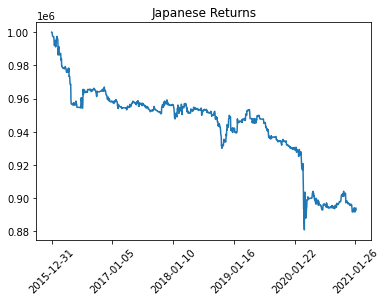

Opening positions:
We sold 649 shares of ADR (HMC) at the price of 30.82914 on 2016-01-04
We bought 649 shares of underlying stock (7267) at the price of 3733.7299999999996 foreign dollars on 2016-01-04
Opening positions:
We sold 32 shares of ADR (TAK) at the price of 24.49548 on 2016-01-04
We bought 16 shares of underlying stock (4502) at the price of 5876.870999999999 foreign dollars on 2016-01-04
Opening positions:
We bought 1219 shares of underlying stock (6758) at the price of 3016.0129999999995 foreign dollars on 2016-01-05
We sold 1219 shares of ADR (SONY) at the price of 24.21576 on 2016-01-06
Closing positions:
We sold 649 shares of underlying stock (7267) at the price of 3622.374 foreign dollars on 2016-01-06

Sharpe Ratio: -0.89


In [21]:
plt.title("Japanese Returns")
plot_returns(dates, portfolio_values)
print("".join(trade_records[:11]))
print("Sharpe Ratio: {}".format(calc_sharpe(portfolio_values)))